In [36]:
import torch
import torch.nn as nn

In [37]:
import sys
sys.path.append('..')

In [38]:
import pybullet_envs
import gym
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from models.ddpg import DDPG
from rl_models.replay_buffer import ReplayBuffer
from rl_models.utils import plot_learning_curve

In [39]:
env = gym.make('InvertedPendulumBulletEnv-v0')
print(env.action_space, env.observation_space.shape)
env.reset()

Box(-1.0, 1.0, (1,), float32) (5,)


array([0.        , 0.        , 0.99542082, 0.09558965, 0.        ])

argv[0]=
argv[0]=


In [47]:
sac = DDPG(env.observation_space.shape[0], 
            action_dim=env.action_space.shape[0], 
            hidden_size=256,
            lr=3e-4, 
            tau=0.5,
            l2_reg=0.01)

In [48]:
best_score = env.reward_range[0]
score_history = []

In [49]:
n_episodes = 250
max_size = 10_000
batch_size = 64

In [50]:
replay_buffer = ReplayBuffer(max_size)

In [51]:
def play_and_record(env, agent, buffer):
    state = env.reset()
    done = False
    score = 0
    while not done:
        state = torch.tensor(state, dtype=torch.float)
        action = sac.choose_action(state)
        next_state, reward, done, _ = env.step(action)
        score += reward

        action = torch.tensor(action, dtype=torch.float)
        next_state = torch.tensor(next_state, dtype=torch.float)
        reward = torch.tensor(reward, dtype=torch.float)
        buffer.add(state, action, reward, next_state, done)

        if len(buffer) > batch_size:
            batch = replay_buffer.sample(batch_size)
            sac.learning_step(batch)
            
        state = next_state
    
    return score

iteration 240 score 139.000 avg_score 765.890


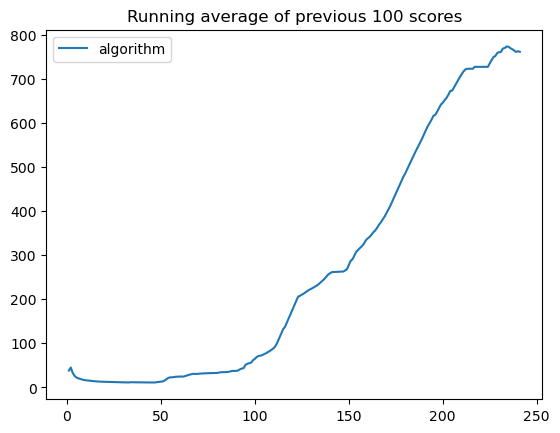

100%|██████████| 250/250 [14:20<00:00,  3.44s/it]


In [52]:
for i in tqdm(range(n_episodes)):
    score = play_and_record(env, sac, replay_buffer)
    sac.update_network_parameters()

    score_history.append(score)
    avg_score = np.mean(score_history[-100:])
    if avg_score > best_score:
        best_score = avg_score
    if i % 10 == 0 and i > 0:
        plot_learning_curve(score_history, running=True) 
        print(f"iteration {i} score {score:.3f} avg_score {avg_score:.3f}")
        plt.show()

    if avg_score > 900:
        plot_learning_curve(score_history, running=True) 
        print(f"iteration {i} score {score:.3f} avg_score {avg_score:.3f}")
        plt.show()
        break

iteration 249 score 136.000 avg_score 775.630


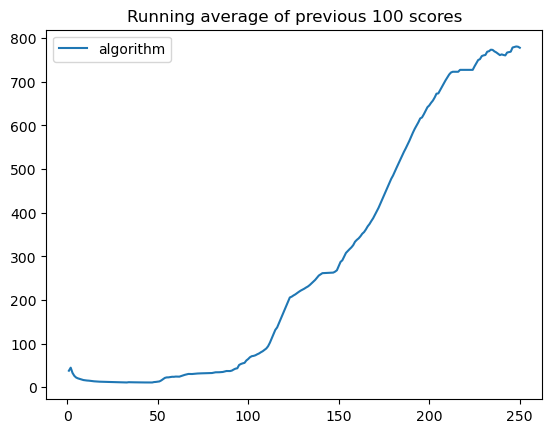

In [53]:
plot_learning_curve(score_history, running=True) 
print(f"iteration {i} score {score:.3f} avg_score {avg_score:.3f}")
plt.savefig('../graphics/test_ddpg.png')
plt.show()